In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    LearningRateMonitor,
    EarlyStopping,
)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from models.lstm.lstm_utils.data_loader import CSVDataLoader
from models.lstm.lstm_utils.utility_functions import df_to_sequences
from models.lstm.lstm_utils.data_module import SpeciesDataModule
from models.lstm.lstm_utils.species_predictor import SpeciesPredictor

TRAIN_PATH = "../../../data/processed/trainset.csv"
VAL_PATH = "../../../data/processed/testset.csv"
TEST_PATH = "../../../data/processed/valset.csv"

loader = CSVDataLoader()
train_df = loader.load_transform(TRAIN_PATH).replace([np.inf, -np.inf], np.nan).fillna(0)
test_df = loader.load_transform(TEST_PATH).replace([np.inf, -np.inf], np.nan).fillna(0)
val_df = loader.load_transform(VAL_PATH).replace([np.inf, -np.inf], np.nan).fillna(0)
print(train_df.shape, test_df.shape, val_df.shape)
train_df

(323400, 37) (46200, 37) (92400, 37)


,time,id,doy,b2,b3,b4,b5,b6,b7,b8,...,ndwi,mtci,rendvi,month_num,year,season,month_sin,month_cos,date_diff,is_growing_season
0,2016-12-26,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,12.0,2016.0,1.0,-2.449294e-16,1.000000e+00,0.0,0.0
1,2017-01-09,4,13.000000,176.000000,229.000000,69.000000,329.000000,996.000000,1113.000000,1067.000000,...,-0.646605,0.719525,0.543689,1.0,2017.0,1.0,5.000000e-01,8.660254e-01,14.0,0.0
2,2017-01-23,4,27.000000,382.000000,429.000000,205.000000,405.000000,1192.000000,1308.000000,1316.000000,...,-0.508309,0.797366,0.527145,1.0,2017.0,1.0,5.000000e-01,8.660254e-01,14.0,0.0
3,2017-02-06,4,38.968169,351.346104,442.016706,252.887318,481.569848,1310.994416,1476.419998,1594.615853,...,-0.551708,0.786998,0.508739,2.0,2017.0,1.0,8.660254e-01,5.000000e-01,14.0,0.0
4,2017-02-20,4,50.000000,240.000000,382.000000,259.000000,544.000000,1387.000000,1609.000000,1825.000000,...,-0.653829,0.747340,0.494659,2.0,2017.0,1.0,8.660254e-01,5.000000e-01,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323395,2022-09-12,2999,248.000000,122.000000,189.000000,172.000000,338.000000,1064.000000,1415.000000,1349.000000,...,-0.754226,0.813901,0.614375,9.0,2022.0,4.0,-1.000000e+00,-1.836970e-16,14.0,1.0
323396,2022-09-26,2999,274.000000,184.000000,262.000000,220.000000,409.000000,1094.000000,1157.000000,1137.000000,...,-0.625447,0.783753,0.477650,9.0,2022.0,4.0,-1.000000e+00,-1.836970e-16,14.0,1.0
323397,2022-10-10,2999,283.000000,272.000000,344.000000,288.000000,463.000000,1137.000000,1215.000000,1195.000000,...,-0.552956,0.793875,0.448153,10.0,2022.0,4.0,-8.660254e-01,5.000000e-01,14.0,1.0
323398,2022-10-24,2999,0.000000,0.000000,0.000000,288.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,10.0,2022.0,4.0,-8.660254e-01,5.000000e-01,14.0,1.0


In [3]:
feature_columns = [
    c
    for c in train_df.columns
    if c not in ["time", "id", "species", "disturbance_year"]
]
label_column = "species"

# Encode labels
le = LabelEncoder()
train_df[label_column] = le.fit_transform(train_df[label_column])
test_df[label_column] = le.transform(test_df[label_column])
val_df[label_column] = le.transform(val_df[label_column])

# Feature scaling
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])
val_df[feature_columns] = scaler.transform(val_df[feature_columns])


# Sequences
train_sequences = df_to_sequences(train_df, feature_columns, label_column)
test_sequences = df_to_sequences(test_df, feature_columns, label_column)
val_sequences = df_to_sequences(val_df, feature_columns, label_column)

data = {
    "train_sequences": train_sequences,
    "test_sequences": test_sequences,
    "val_sequences": val_sequences,
    "feature_columns": feature_columns,
    "n_classes": len(le.classes_),
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

In [4]:
batch_size = 16
lr = 1e-3
max_epochs = 5

labels = [y for _, y in train_sequences]
counts = Counter(labels)
class_weights = [
    1.0 / counts[i] if i in counts else 0.0 for i in range(data["n_classes"])
]

data_module = SpeciesDataModule(
    train_sequences, test_sequences, val_sequences, batch_size
)
model = SpeciesPredictor(len(feature_columns), data["n_classes"], lr, class_weights)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="trained_model/",
    filename="species_model-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
        EarlyStopping(monitor="val_acc", patience=10),
    ],
)

trainer.fit(model, datamodule=data_module)
trainer.test(model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-10-17 11:55:20.726725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-17 11:55:20.749078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-17 11:55:20.749122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-17 11:55:20.762550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operation

Epoch 4: 100%|██████████| 132/132 [00:53<00:00,  2.48it/s, v_num=46, train_loss=1.770, train_acc=0.250, val_loss=0.790, val_acc=0.667]

`Trainer.fit` stopped: `max_epochs=5` reached.


Testing DataLoader 0: 100%|██████████| 19/19 [00:02<00:00,  7.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6633333563804626     │
│         test_loss         │    0.9354425072669983     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9354425072669983, 'test_acc': 0.6633333563804626}]

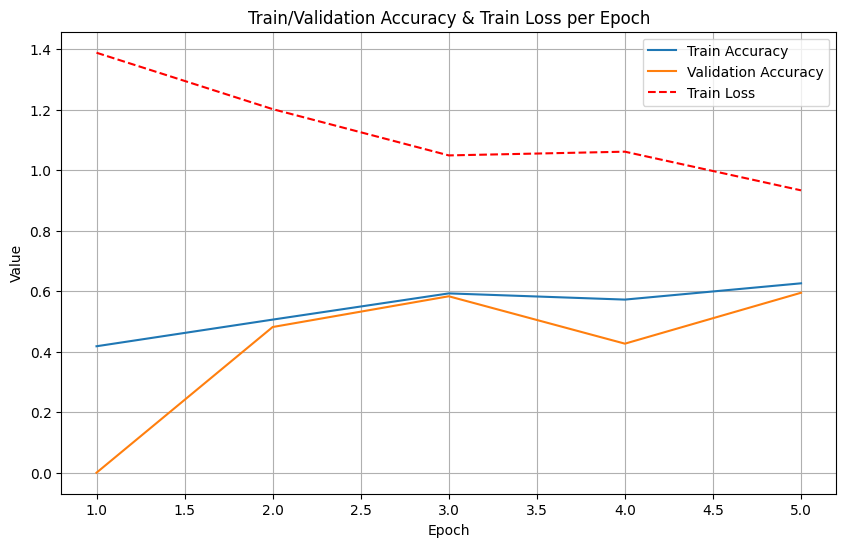

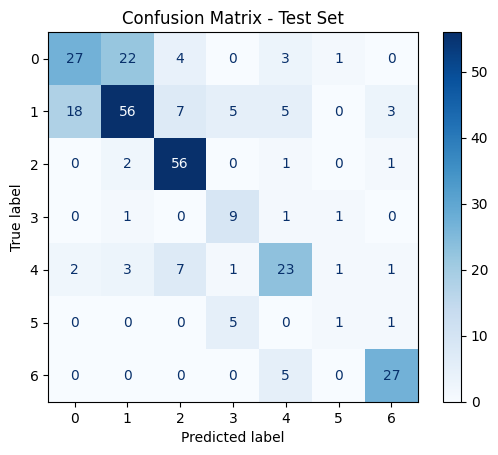

In [5]:
plt.figure(figsize=(10, 6))


min_len = min(
    len(model.train_acc_history),
    len(model.train_loss_history),
    len(model.val_acc_history),
)

epochs = range(1, min_len + 1)

# Listen auf gleiche Länge kürzen
train_acc = model.train_acc_history[:min_len]
train_loss = model.train_loss_history[:min_len]
val_acc = model.val_acc_history[:min_len]

# Plot Accuracy + Loss
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.plot(epochs, train_loss, label="Train Loss", linestyle="--", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Train/Validation Accuracy & Train Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
all_labels, all_preds = [], []
device = data["device"]

for batch in data_module.test_dataloader():
    seq_batch = batch["sequence"].to(device)
    labels = batch["label"].to(device)
    with torch.no_grad():
        outputs = model(seq_batch)
        preds = torch.argmax(outputs, dim=1)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

Top 15 Feature Importances:
b5: 0.0405
b3: 0.0361
b2: 0.0263
b11: 0.0175
rendvi: 0.0175
ndwi: 0.0175
gndvi: 0.0175
b8: 0.0164
wdvi: 0.0164
b6: 0.0142
b12: 0.0109
ndmi: 0.0109
masvi2: 0.0109
b4: 0.0076
b7: 0.0065


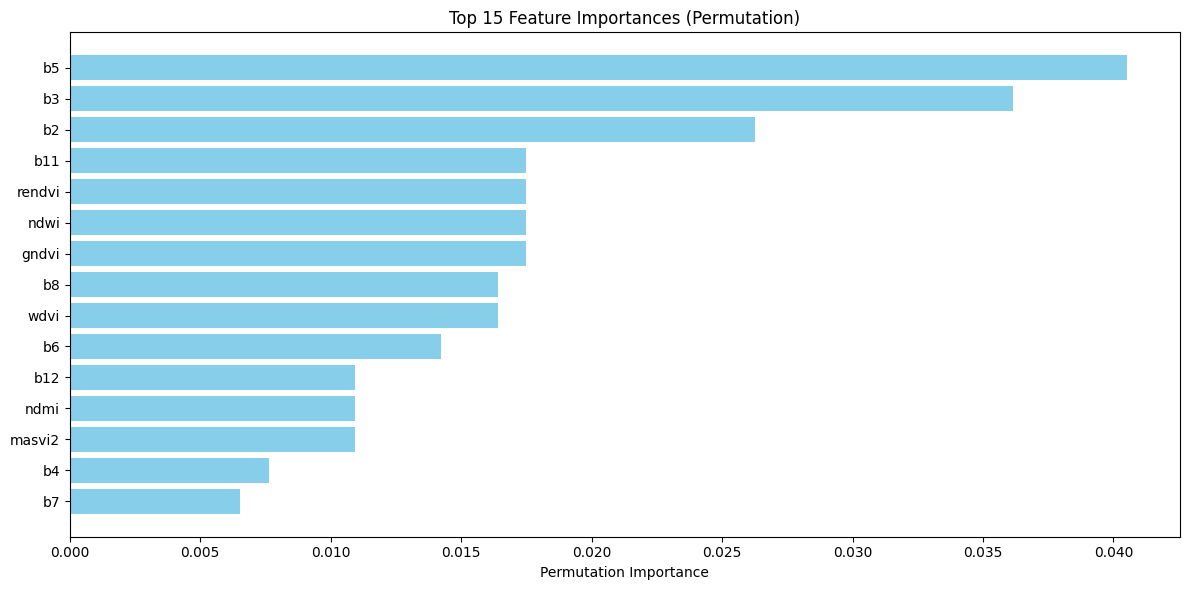

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def permutation_importance(model, data_loader, n_features):
    baseline_acc = evaluate_accuracy(model, data_loader)
    importances = np.zeros(n_features)
    
    for i in range(n_features):
        acc_drop = []
        for batch in data_loader:
            x = batch["sequence"].clone()
            y = batch["label"]
            
            # Feature i permutieren
            idx = torch.randperm(x.size(0))
            x[:, :, i] = x[idx, :, i]
            
            with torch.no_grad():
                outputs = model(x.to(model.device))
                preds = torch.argmax(outputs, dim=1)
            acc_drop.append((preds.cpu() == y).float().mean().item())
        
        permuted_acc = np.mean(acc_drop)
        importances[i] = baseline_acc - permuted_acc
    
    return importances

def evaluate_accuracy(model, data_loader):
    correct, total = 0, 0
    for batch in data_loader:
        x = batch["sequence"].to(model.device)
        y = batch["label"].to(model.device)
        with torch.no_grad():
            preds = torch.argmax(model(x), dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

# Permutation Importances berechnen (dein bestehender Code)
data_loader = data_module.test_dataloader()
feature_importances = permutation_importance(model, data_loader, len(feature_columns))

# Sortieren absteigend
sorted_idx = np.argsort(feature_importances)[::-1]  # Index der Features nach Importance
sorted_features = [feature_columns[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Nur Top 15
top_n = 15
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Ausgabe in Konsole
print("Top 15 Feature Importances:")
for f, imp in zip(top_features, top_importances):
    print(f"{f}: {imp:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.barh(top_features[::-1], top_importances[::-1], color="royalblue")  
plt.xlabel("Permutation Importance")
plt.title("Top 15 Feature Importances (Permutation)")
plt.tight_layout()
plt.show()
